# C-More

[C-More](https://github.com/mknoll/cmoRe) (cellular morphology recognition)
is a workflow for image-based profiling of cardiomyocytes.
It was originally described for the analysis of neonatal rat cardiomyocytes (NRCM) and induced pluripotent
stem cell-derived cardiomyocytes (hiPSC-CMs). However, it can also be used for other cell types.
Morphelia implements many ot the methods used in C-More. The implemented steps are described in this notebook.

For further information about C-More we refer to the [publication](https://pubmed.ncbi.nlm.nih.gov/34841289/):

```
Furkel J, Knoll M, Din S, Bogert NV, Seeger T, Frey N, Abdollahi A, Katus HA, Konstandin MH.
C-MORE: A high-content single-cell morphology recognition methodology for liquid biopsies
toward personalized cardiovascular medicine. Cell Rep Med. 2021 Nov 3;2(11):100436.
doi: 10.1016/j.xcrm.2021.100436. PMID: 34841289; PMCID: PMC8606902.
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import anndata as ad
import numpy as np
import pandas as pd

import morphelia

### Step 1: Load data


In [2]:
path = '../data/'

adata = ad.read_h5ad(os.path.join(path, 'test_plate.h5ad'))
adata


AnnData object with n_obs × n_vars = 54628 × 889
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Well', 'Metadata_Concentration', 'Metadata_Treatment'

### Step 2: Handle invalid values

This step is similar to but not exactly like C-More and can be used as a
good data-cleaning heuristic.

Cleaning is done in three simple steps:
1. Nan-values
    * drop features that contain Nan-values above a certain threshold
    * drop cells that contain remaining Nan-values
2. Duplicated features / cells
    * Drop cells and features that are duplicates
3. Invariant features / cells
    * Drop cells and features that contain the same value along the axis


In [3]:
# nan values
adata = morphelia.pp.drop_nan(adata, axis=0, min_nan_frac=0.5, verbose=True)
adata = morphelia.pp.drop_nan(adata, axis=1, verbose=True)

INFO:morphelia.preprocessing.basic:Dropped 0 features with missing values: []
INFO:morphelia.preprocessing.basic:Dropped 49 cells with missing values: ['3444', '3477', '4356', '4645', '4646', '6438', '6513', '6514', '10772', '12112', '12982', '16324', '19796', '20017', '20018', '20254', '20255', '20610', '20646', '21932', '22335', '22336', '22340', '22341', '24101', '27557', '29663', '30024', '30025', '31131', '31353', '31952', '32604', '33617', '34700', '35071', '35072', '35073', '35133', '36104', '39504', '41107', '43708', '45638', '45691', '46042', '48305', '53695', '54155']


In [4]:
# duplicated features / cells
adata = morphelia.pp.drop_duplicates(adata, axis=1, verbose=True)
adata = morphelia.pp.drop_duplicates(adata, axis=0, verbose=True)

INFO:morphelia.preprocessing.basic:Dropped 66 duplicated features: ['Primarieswithoutborder_Granularity_10_DNA.1', 'Primarieswithoutborder_Granularity_11_DNA.1', 'Primarieswithoutborder_Granularity_12_DNA.1', 'Primarieswithoutborder_Granularity_13_DNA.1', 'Primarieswithoutborder_Granularity_14_DNA.1', 'Primarieswithoutborder_Granularity_15_DNA.1', 'Primarieswithoutborder_Granularity_16_DNA.1', 'Primarieswithoutborder_Granularity_17_DNA.1', 'Primarieswithoutborder_Granularity_18_DNA.1', 'Primarieswithoutborder_Granularity_19_DNA.1', 'Primarieswithoutborder_Granularity_1_DNA.1', 'Primarieswithoutborder_Granularity_20_DNA.1', 'Primarieswithoutborder_Granularity_21_DNA.1', 'Primarieswithoutborder_Granularity_22_DNA.1', 'Primarieswithoutborder_Granularity_23_DNA.1', 'Primarieswithoutborder_Granularity_24_DNA.1', 'Primarieswithoutborder_Granularity_25_DNA.1', 'Primarieswithoutborder_Granularity_26_DNA.1', 'Primarieswithoutborder_Granularity_27_DNA.1', 'Primarieswithoutborder_Granularity_28_D

In [5]:
# invariant features / cells
adata = morphelia.pp.drop_invariant(adata, axis=0, verbose=True)
adata = morphelia.pp.drop_invariant(adata, axis=1, verbose=True)

INFO:morphelia.preprocessing.basic:Dropped 1 invariant features: Index(['Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_0_0'], dtype='object')
INFO:morphelia.preprocessing.basic:Dropped 0 invariant cells: Index([], dtype='object')


### Step 3: Preprocessing

C-More utilizes the following preprocessing steps:

1. Quality control:
    * controls the number of cells per well and exclude wells with low cell counts
2. Find secondary annotations:
    * find dead cells based on a low Cell Area to Nucleus Area ratio
    * find cell cycle state based on integrated DAPI intensity within the nucleus object
    * distinguish fibroblasts from cardiomyocytes based on the median DAPI intensity within the nucleus object
3. Normalization:
    * z-transformation per experiment

For the quality control step the data needs to be aggregated and counted per Well.
This adds the observation "Metadata_Cellnumber" to obs, which we can use next.

In [6]:
# aggregate
agg = morphelia.pp.aggregate(adata, by='Metadata_Well')
agg

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 95 × 822
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Well', 'Metadata_Concentration', 'Metadata_Treatment', 'Metadata_Cellnumber'

(<Figure size 1080x504 with 2 Axes>, <AxesSubplot:>)

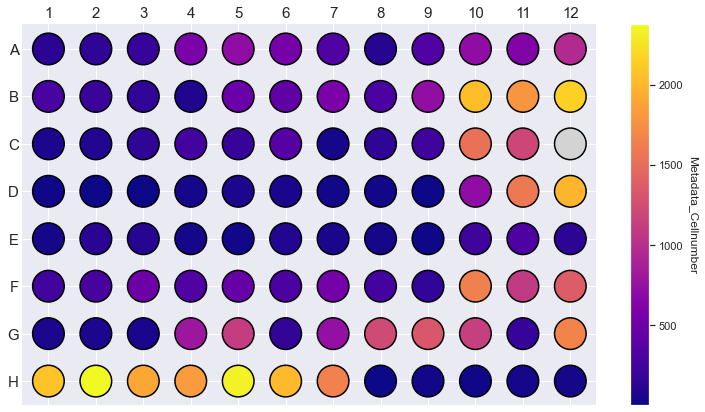

In [7]:
# quality control
morphelia.pl.plot_plate(agg, color='Metadata_Cellnumber')

In C-More dead cells, cell cycle states and cell types are assigned by finding local
and global maxima of different distributions.
With Morphelia we can use different thresholding strategies (from scikit-image) to assign
labels by thresholding different distributions.
Thresholding is typically done per plate, since distributions can vary between different experimental conditions.


### Debris filter

Because dead cardiomyocytes typically have a reduced cell body size and don't show any cell protrusions,
they express a very low cell area to nucleus area ratio.
We use this ratio to find a threshold to distinguish between vital and dead cells.
Note that in this example, the dead cell population is very small.

In [8]:
nucl_area = 'Primarieswithoutborder_AreaShape_Area'
cell_area = 'Cells_AreaShape_Area'
debris_dist = adata[:, cell_area].X / adata[:, nucl_area].X

In [9]:
# colors for dead and vital in plot
class_colors = ['#DD4A48', '#C0D8C0']
class_labels = ['dead', 'vital']

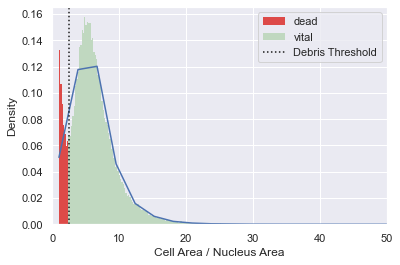

In [10]:
adata = morphelia.pp.assign_by_threshold(adata, dist=debris_dist,
                                         new_var='Debris',
                                         method='otsu',
                                         max_val=4,
                                         threshold_labels='Debris Threshold',
                                         make_plot=True,
                                         plt_xlim=(0, 50),
                                         class_colors=class_colors,
                                         class_labels=class_labels,
                                         xlabel='Cell Area / Nucleus Area')

In [11]:
adata.obs['Debris'].value_counts()

vital    47805
dead      6774
Name: Debris, dtype: int64

In [12]:
# only keep vital cells
adata = adata[adata.obs['Debris'] == 'vital', :].copy()

### Cell type filter

As said before, this experiment analyses images of neonatal rat cardiomyocytes.
Since they are obtained of whole heart lysate, the cell culture also contains other cells, mainly fibroblasts.
Fibroblasts have a larger nucleus and a lower DAPI intensity than cardiomyocytes and can thus
be filtered for downstream analysis.


In [13]:
median_intens = 'Primarieswithoutborder_Intensity_MedianIntensity_DNA'

In [14]:
class_colors = ['#ECB390', '#886F6F']
class_labels = ['cardiomyocyte', 'fibroblast']

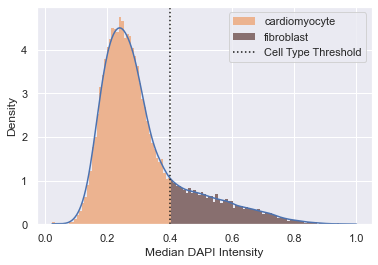

In [15]:
adata = morphelia.pp.assign_by_threshold(adata, dist=median_intens,
                                         new_var='Cell_Type',
                                         method='otsu',
                                         threshold_labels='Cell Type Threshold',
                                         make_plot=True,
                                         class_colors=class_colors,
                                         class_labels=class_labels,
                                         xlabel='Median DAPI Intensity')

In [16]:
adata.obs['Cell_Type'].value_counts()

cardiomyocyte    38242
fibroblast        9563
Name: Cell_Type, dtype: int64

In [17]:
# only keep cardiomyocytes
adata = adata[adata.obs['Cell_Type'] == 'cardiomyocyte', :].copy()

### Cell cycle filter

Like before, we distinguish two populations based on their DAPI intensity.
To find cell cycle phases, the integrated DAPI intensity is used.
Normally, cardiomyocytes are in a postmitotic state. However, neonatal cardiomyocytes can also
show a cell cycle activation.
Since almost no cells show mitosis, we devide the population in G1 (cell growth, low intensity) and
S/G2 (synthesis, preparation for mitotis, high intensity). Threshold are calculated for every cell type
separately.

In [18]:
integr_intens = 'Primarieswithoutborder_Intensity_IntegratedIntensity_DNA'

In [19]:
class_colors = ['#CE7BB0', '#6867AC']
class_labels = ['G1', 'S/G2']

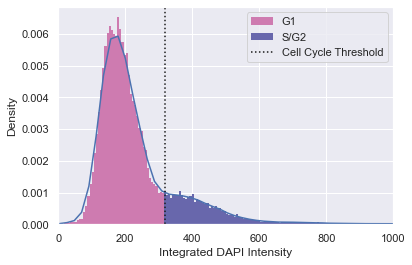

In [20]:
adata = morphelia.pp.assign_by_threshold(adata, dist=integr_intens,
                                         new_var='Cell_Cycle',
                                         method='otsu',
                                         threshold_labels='Cell Cycle Threshold',
                                         make_plot=True,
                                         plt_xlim=(0, 1000),
                                         class_labels=class_labels,
                                         class_colors=class_colors,
                                         xlabel='Integrated DAPI Intensity')


In [21]:
adata.obs['Cell_Cycle'].value_counts()

G1      31440
S/G2     6802
Name: Cell_Cycle, dtype: int64

### Normalization

C-More normalized the data by z-transformation experiment-wise to handle experiment-specific effect.
With Morphelia we can also normalize by subtracting the median and dividing by the median absolute
deviation which is more robust to outliers.
Further more we can calculate the relevant statistics only on a specified subpolulation, i.e. the control group.

In [22]:
adata = morphelia.pp.normalize(adata, method='mad_robust',  # --> otherwise 'standard'
                               by=None,             # --> specify batch variable if adata contains multiple batches
                               pop_var="Metadata_Treatment",
                               norm_pop='ctrl',     # --> population to calculate statistics on
                               drop_nan=True,       # --> drop features containing nan values after normalization
                               verbose=True)

INFO:morphelia.preprocessing.basic:Dropped 27 features with missing values: ['Primarieswithoutborder_Granularity_20_DNA', 'Primarieswithoutborder_Granularity_21_DNA', 'Primarieswithoutborder_Granularity_22_DNA', 'Primarieswithoutborder_Granularity_23_DNA', 'Primarieswithoutborder_Granularity_24_DNA', 'Primarieswithoutborder_Granularity_25_DNA', 'Primarieswithoutborder_Granularity_26_DNA', 'Primarieswithoutborder_Granularity_27_DNA', 'Primarieswithoutborder_Granularity_28_DNA', 'Primarieswithoutborder_Granularity_29_DNA', 'Primarieswithoutborder_Granularity_30_DNA', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_4_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_6_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_DNA_8_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_Desmin_2_0', 'Primarieswithoutborder_RadialDistribution_ZernikePhase_Desmin_4_0', 'Primarieswithoutborder_Ra

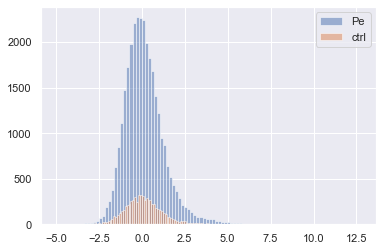

In [23]:
import matplotlib.pyplot as plt

for treat in adata.obs['Metadata_Treatment'].unique():
    x = adata[adata.obs['Metadata_Treatment'] == treat, 100].X.copy().flatten()
    p = plt.hist(x, bins=100, label=treat, alpha=0.5)
plt.legend()

### Step 4: Feature selection

To account for random effects of biological replicates and plates, C-More uses linear mixed effect
models. The independent variables (or fixed effects) are the control condition together with dose steps
of a certain treatment assuming equal distance between them.
They are modelled against every feature (dependent variable) considering other given random effects.
For every feature we get a combined R-squared and a p-value, which is corrected for multiple testing.
Based on this information we can keep features that satisfy our thresholds.

In [24]:
# aggregation
agg = morphelia.pp.aggregate(adata, by='Metadata_Well', method='median')

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
# we have only one treatment ('Pe') and control
agg.obs['Metadata_Treatment'].unique()

array(['ctrl', 'Pe'], dtype=object)

In [26]:
agg = morphelia.ft.feature_lmem(agg,
                                treat_var='Metadata_Treatment',
                                rand_var=['BatchNumber', 'PlateNumber'],   # --> random effect
                                fixed_var='Metadata_Concentration') # --> fixed effect


INFO:morphelia.features.lmem:Fit LME on Pe [Metadata_Treatment]
INFO:morphelia.features.lmem:Independent variables: {0: 0, 1: 1, 2: 2, 3: 3}
Fitting LME-Model on every feature...:  39%|███▉      | 311/795 [00:14<00:15, 30.34it/s]INFO:morphelia.features.lmem:Raised exception at features: Primarieswithoutborder_Texture_SumVariance_DNA_10_01
INFO:morphelia.features.lmem:Raised exception at features: Primarieswithoutborder_Texture_SumVariance_DNA_10_03
Fitting LME-Model on every feature...:  82%|████████▏ | 649/795 [00:29<00:04, 30.50it/s]INFO:morphelia.features.lmem:Raised exception at features: Cells_Texture_InfoMeas2_Desmin_10_01
INFO:morphelia.features.lmem:Raised exception at features: Cells_Texture_InfoMeas2_Desmin_10_02
Fitting LME-Model on every feature...: 100%|██████████| 795/795 [00:35<00:00, 22.45it/s]


All evaluation metrics are stored in .var and can be used to filter significant features.
lme_combined_mask masks all features that are either True for r2_mask or True for p_mask.
r2_mask masks all features that have a combined R-squared value > r2_thresh.
p_mask masks all features that have at least for one treatment a p-value < alpha.

We can plot the model for specific features as following:

In [27]:
agg.var

,r2_mean,r2_std,r2_Pe,p_Pe,r2_mask,p_mask,lme_combined_mask
Primarieswithoutborder_AreaShape_Area,0.0,NaN,0,0.001962,False,True,True
Primarieswithoutborder_AreaShape_Compactness,0.0,NaN,0,0.176488,False,False,False
Primarieswithoutborder_AreaShape_Eccentricity,0.0,NaN,0,0.693748,False,False,False
Primarieswithoutborder_AreaShape_Extent,0.0,NaN,0,0.251895,False,False,False
Primarieswithoutborder_AreaShape_FormFactor,0.0,NaN,0,0.232703,False,False,False
...,...,...,...,...,...,...,...
Cytoplasm_Intensity_StdIntensityEdge_Desmin,0.0,NaN,0,0.030234,False,True,True
Cytoplasm_Intensity_StdIntensity_DNA,0.0,NaN,0,0.813091,False,False,False
Cytoplasm_Intensity_StdIntensity_Desmin,0.0,NaN,0,0.000309,False,True,True
Cytoplasm_Intensity_UpperQuartileIntensity_DNA,0.0,NaN,0,0.002638,False,True,True


In [28]:
n_significant_features = agg.var['lme_combined_mask'].sum()
print(f"{n_significant_features} significant features found.")

298 significant features found.


In [29]:
# show significant features

var = agg.var_names[agg.var['lme_combined_mask']][20]
print(f"Significant feature {var}")

Significant feature Primarieswithoutborder_Intensity_MedianIntensity_Desmin


INFO:morphelia.plotting.lmem:Independent variables: {0: 0, 1: 1, 2: 2, 3: 3}
INFO:morphelia.plotting.lmem:Fit LME on Pe [Metadata_Treatment]
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


{0: 'ctrl_0', 1: 'Pe_1', 2: 'Pe_2', 3: 'Pe_3'}


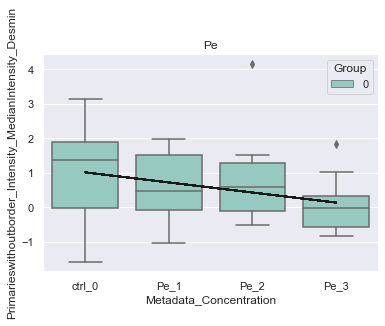

In [30]:
plot = morphelia.pl.plot_lmem(agg, var)


In [31]:
# show insignificant features
var = agg.var_names[~agg.var['lme_combined_mask']][10]
print(f"Insignificant feature: {var}")

Insignificant feature: Primarieswithoutborder_AreaShape_Zernike_1_1


INFO:morphelia.plotting.lmem:Independent variables: {0: 0, 1: 1, 2: 2, 3: 3}
INFO:morphelia.plotting.lmem:Fit LME on Pe [Metadata_Treatment]
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


{0: 'ctrl_0', 1: 'Pe_1', 2: 'Pe_2', 3: 'Pe_3'}


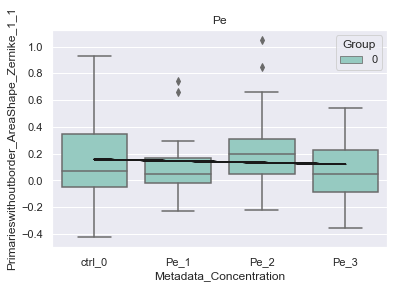

In [32]:
plot = morphelia.pl.plot_lmem(agg, var)


Finally we can delete all insignificant features using the 'lme_combined_mask'


In [33]:
len_before = len(agg.var_names)
agg = agg[:, agg.var['lme_combined_mask']]
print(f"{len_before - len(agg.var_names)} features deleted with insignificant features.")

497 features deleted with insignificant features.


### Step 5: Feature agglomeration

C-More shows that Cellprofiler features can be clustered. Features within a specific cluster
share similar biological information and can thus be replaced by an agglomerated feature vector.
In Morphelia we use a wrapper for scikit-learns
[Feature Agglomeration](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html).
Features are recursively merged to clusters by hierachrical clustering and pooled by a aggregation function (i.g. mean).
We estimate be best number of k clusters by calculating the silhouette score for a range of ks.
Typically, the global maximum is chosen to be the best k.

Testing 2 to 100 ks: 100%|██████████| 98/98 [00:02<00:00, 43.02it/s]


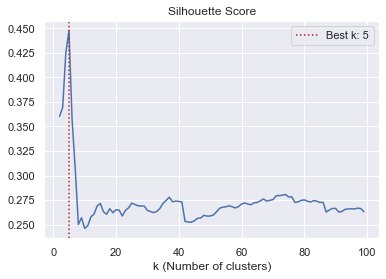

In [34]:
# estimate the best value for k and make a plot for validation
best_k = morphelia.ft.estimate_k(agg, cluster_range=(2, 100),
                                 make_plot=True)

The silhouette score seams to reach a global maximum if k equals 5.
We use this information to agglomerate our > 200 features into 5 agglomerated features.

In [35]:
agg = morphelia.ft.feature_agglo(agg, k=best_k)

In [36]:
agg

AnnData object with n_obs × n_vars = 95 × 5
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Well', 'Metadata_Concentration', 'Metadata_Treatment', 'Debris', 'Cell_Type', 'Cell_Cycle', 'Metadata_Cellnumber'
    uns: 'agglo_feats'

### Step 6: Visualization

Visualize sample and feature clusters.

(<Figure size 432x288 with 0 Axes>, <AxesSubplot:>)

<Figure size 432x288 with 0 Axes>

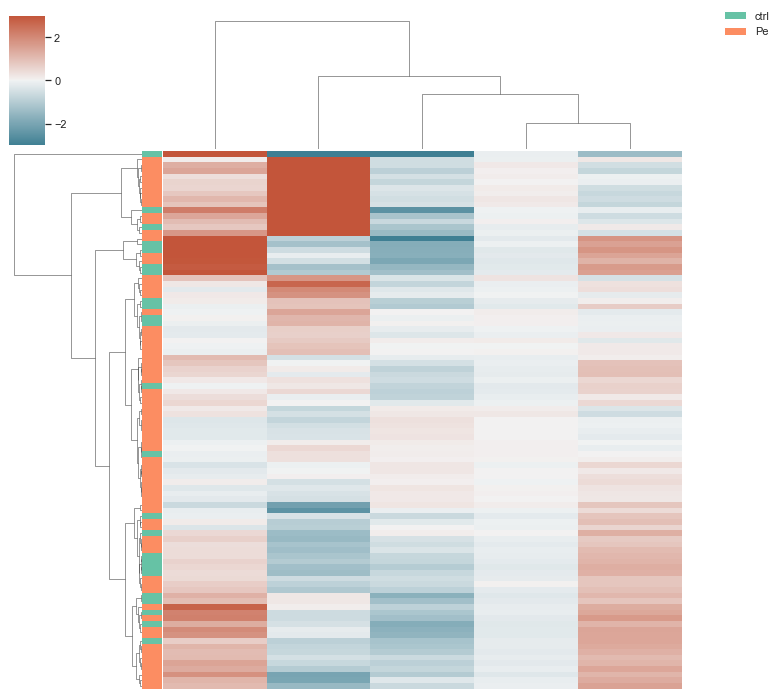

In [37]:
# with aggregated data after feature selection
morphelia.pl.clustermap(agg,
                        group_by='Metadata_Treatment')

(<Figure size 432x288 with 0 Axes>, <AxesSubplot:>)

<Figure size 432x288 with 0 Axes>

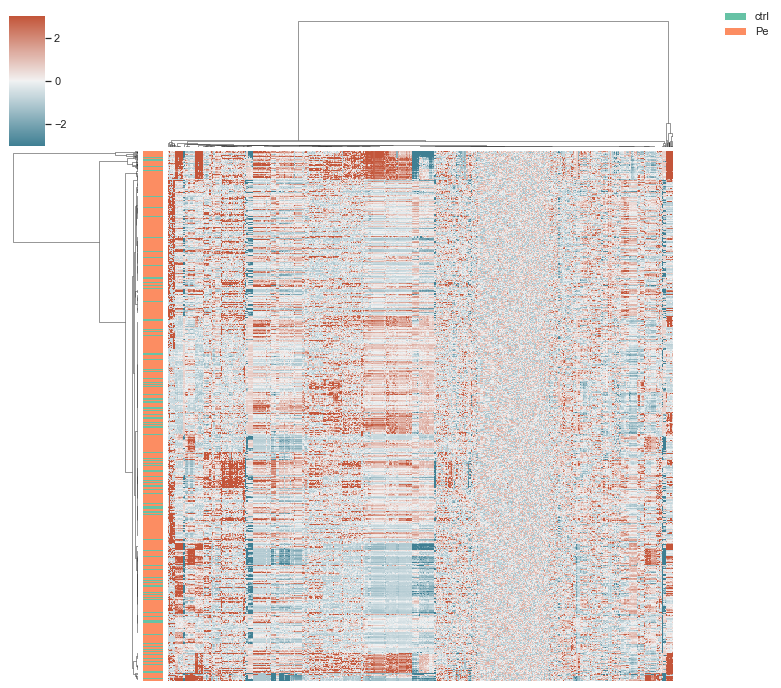

In [38]:
# with single-cell data before feature selection
morphelia.pl.clustermap(adata,
                        subsample=True,
                        group_by='Metadata_Treatment')

Since Morphelia integrated well with scanpy, we can use rank_genes_groups to
test treatments against the control condition and plot a volcano plot.


In [39]:
import scanpy as sc

In [40]:
sc.tl.rank_genes_groups(adata, groupby='Metadata_Treatment',
                        method='wilcoxon', reference='ctrl')


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Debris' as categorical
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Cell_Type' as categorical
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future vers

['Pe']


C:\Users\amarx\PycharmProjects\Morphelia\morphelia\plotting\volcano.py:92: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(lfc, -np.log10(pv), color=c, s=scatter_size)


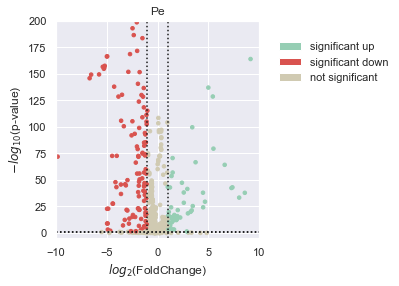

In [41]:
morphelia.pl.volcano_plot(adata,
                          xlim=(-10, 10),
                          ylim=(-5, 200),
                          show=True)